<div style="text-align: right">INFO 7390 Advances Data Sciences and Architecture SEC 03 Spring 2024</div>
<div style="text-align: right">Understanding Data - Assignment 1</div>
<div style="text-align: right">Aditi A. Deodhar, NUID: 002279575</div>

# Worked Example  1

For a UI experiment, we’ll look at user engagement with different variants of the new UI feature. For an experiment that aims to engage the users more, we’ll measure if members are using the app a bit more. 

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

C:\Users\aditi\AppData\Local\Temp\ipykernel_32036\2203459165.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


We will be using this [Kaggle](https://www.kaggle.com/ivanpl/a-b-testing/data) dataset which contains the results of an A/B test on what seems to be 2 different designs of a website page (old UI vs. new UI). Let's hypothesize the Web site is an Amazon page that sells shampoos.

Suppose the product manager (PM) tells you that the current conversion rate (how many people buy the shampoo over how many people view the Web page) is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new UI design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs.

In [2]:
df = pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.converted.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

For our test we’ll need two groups:
- A control group - They'll be shown the *old* UI
- A treatment (or experimental) group - They'll be shown the *new* UI

In [5]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :
- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

We’ll actually only use the group and converted columns for the analysis.

Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [6]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


There are, in fact, 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice:

In [7]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


To perform a **hypothesis test**, we establish the following:
- The **null hypothesis** that we want to test for is that the two pages' conversion rates are equal
- The **alternative** is that they differ (one is higher than the other). 

What's the right sample size based on our significance level (alpha = 5%), effect size (above), and power (80%)?

We have already specified the three key components of a power analysis:

A decision rule of when to reject the null hypothesis. We reject the null when the p-value is less than 5%
Our tolerance for committing type 2 error (1 − 80% = 20%)
The detectable difference, i.e. the level of impact we want to be able to detect with our test

In [8]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
required_n

4720

Now that our DataFrame is nice and clean, we can proceed and sample $n=4720$ entries for each of the groups. 

We can use pandas `DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us.

We set random_state=22 so that the results are reproducible.

In [9]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [10]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [11]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [12]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging by the stats above, it does look like our two designs performed similarly, with our new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate.

C:\Users\aditi\AppData\Local\Temp\ipykernel_32036\1510267236.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found

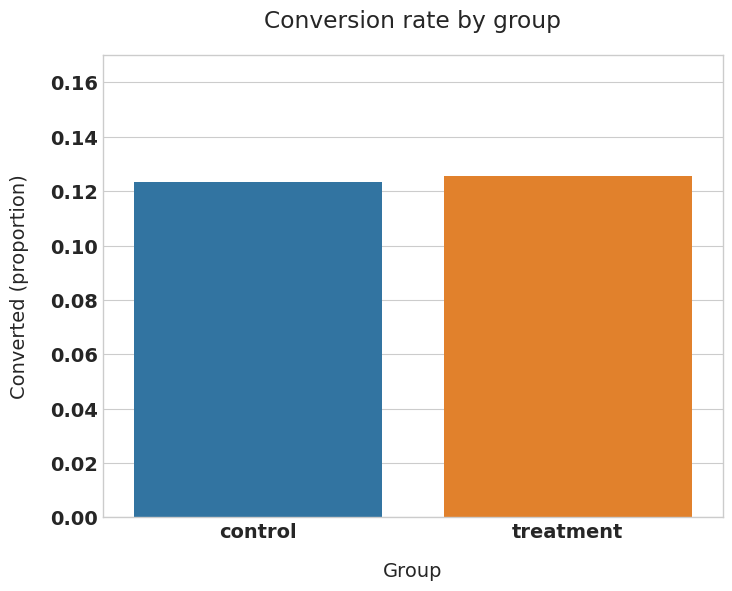

In [13]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So… the treatment group's value is higher. Is this difference actually *statistically significant*?

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal (gaussian) approximation for calculating our p-value, i.e. we use the z-test.

If we had assumed a student-T statistic, we would perform a t-test.

We use the `statsmodels.stats.proportion` module to get the p-value and confidence intervals:

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


### Conclusion:

Since our p-value$=0.732$ is way above our $α=0.05$ threshold, *we cannot reject the Null hypothesis $Hₒ$*, which means that our new design did not perform significantly different (let alone better) than our old one.

<br />

Additionally, if we look at the confidence interval for the treatment group (\[0.116, 0.135\], or 11.6-13.5%) we notice that:

- It includes our baseline value of 13% conversion rate
- It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design!

# Worked Example 2

The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment (`drug`) and control (`placebo`) arms, respectively, and these are their post-trial IQs. An IQ between 90 and 110 is considered average; over 120, superior.

Note that although our IQ data is integer type, our datasets here could easily be real-valued, and so we consider our random variable to be **continuous**.

In [15]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

array([<Axes: title={'center': 'drug'}>,
       <Axes: title={'center': 'placebo'}>], dtype=object)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

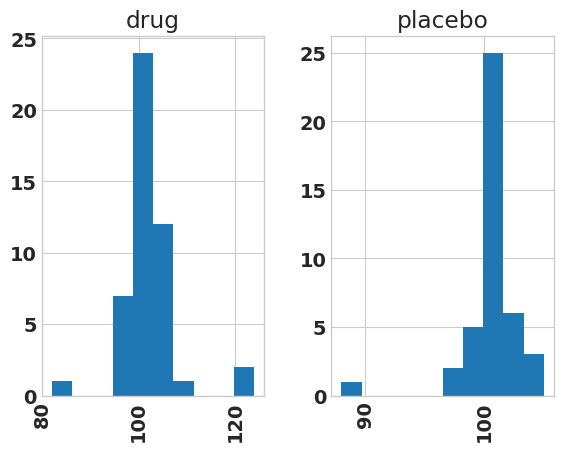

In [16]:
trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group')

C:\Users\aditi\AppData\Local\Temp\ipykernel_32036\2484180781.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(A,bins=bins,label='Drug Group')
C:\Users\aditi\AppData\Local\Temp\ipykernel_32036\2484180781.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(B,bins=bins,label='Place

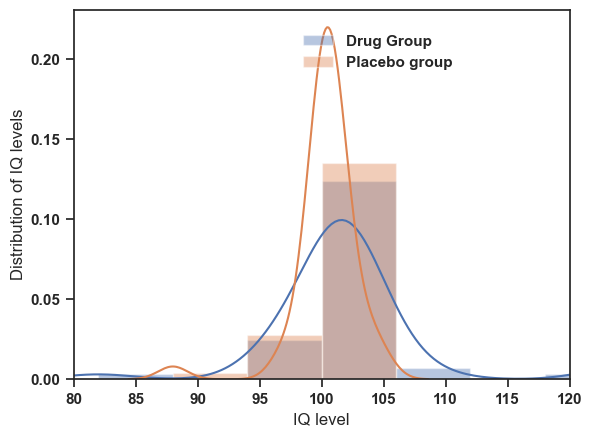

In [17]:
# Let's visualize the data with seaborn, which also gives us a kde estimate
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

bins = np.arange(70,150,6)

A = drug.iq.values
B = placebo.iq.values

# Show the results of a linear regression within each dataset
ax1 = sns.distplot(A,bins=bins,label='Drug Group')
ax2 = sns.distplot(B,bins=bins,label='Placebo group')

plt.pyplot.xlabel('IQ level')
plt.pyplot.ylabel('Distribution of IQ levels')
plt.pyplot.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)

plt.pyplot.xlim((80,120))
plt.pyplot.show()

In [18]:
# packing the data into a tidy dataframe can be nice
exp_df = pd.DataFrame(dict(group=[0]*len(drug.iq)+[1]*len(placebo.iq), score=np.r_[drug.iq,placebo.iq]))

exp_df.head()

,group,score
0,0,101
1,0,100
2,0,102
3,0,104
4,0,102


In [19]:
# printing the results
import scipy.stats as stats
combined_iq = np.concatenate((drug.iq, placebo.iq))
print(len(drug.iq))
print(len(placebo.iq))
print( drug.iq.mean() )
print( placebo.iq.mean() )
print( drug.iq.var() )
print( placebo.iq.var() )
print( combined_iq.mean() )
stats.ttest_ind(a= drug.iq,
                b= placebo.iq,
                equal_var=False) 

47
42
101.91489361702128
100.35714285714286
36.25346901017574
6.332752613240418
101.17977528089888


Ttest_indResult(statistic=1.622190457290228, pvalue=0.10975381983712831)

### Conclusion

The results show that the t-value for the mean difference is 1.622. The p-value is 0.11 which is greater than the traditional "alpha" cut off at p=0.05. Therefore this test is *not significant*: The null hypothesis is in effect.

The test yields a p-value of 0.11 means ***there is a 11% chance we'd see sample data this far apart statistically if the two groups tested are actually identical***. 

If we were using a 95% confidence level, we would **fail** to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 0.05. And so we conclude that the drug is as effective as placebo at a 95% confidence level: there is nothing interesting going on. At a significance level of 0.05, our drug outcome on IQ is statistically **nonsignificant**.